In [4]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import spacy

import keras
from keras import layers
from keras.utils import to_categorical

from html import unescape

Using TensorFlow backend.


In [1]:
!python -m spacy download en_core_web_lg

import spacy
nlp = spacy.load('en_core_web_lg')

In [5]:
### plotting ###
# prettier and larger basic graphs
sns.set(rc={
    'figure.figsize':(18,8),
    'axes.titlesize':14,
})

### pandas ###
# no need to see many decimal places and makes nicer horizontal fits :-)
pd.options.display.float_format = '{:.3f}'.format
# pd.options.display.precision = 3
# make the tables more compact vertically, too
pd.options.display.max_rows = 20

### numpy ###
# same as for pandas - max. 3 decimal places
np.set_printoptions(formatter={'float_kind':'{:.3f}'.format})
# np.set_printoptions(precision=3)

In [6]:
print(os.listdir("../input"))

['drugsComTrain_raw.csv', 'drugsComTest_raw.csv']


In [97]:
reviews_df = pd.read_csv('../input/drugsComTrain_raw.csv').sample(30000, random_state=0)
reviews_df

,uniqueID,drugName,condition,review,rating,date,usefulCount
137738,48134,Nubain,Pain,"""I recently received an injection of nalbuphin...",9,30-May-11,12
125778,43221,Hydromorphone,Pain,"""I went to the emergency room in the worst pai...",10,4-Oct-17,1
26647,109628,Nexplanon,Birth Control,"""HORRIBLE! I was not myself at all. I cried ev...",1,14-Sep-16,7
89592,90397,Docosanol,Herpes Simplex,"""I use this medication daily and by doing this...",10,12-May-17,1
83605,6631,Primidone,Benign Essential Trem,"""Tremors seem to be getting worse. I take 2 a ...",3,8-Dec-16,10
105081,35875,Buprenorphine / naloxone,Opiate Dependence,"""My wife and I have been on Suboxone for about...",10,4-Jun-14,54
15387,170182,Quetiapine,Borderline Personality Disorde,"""Quitiapine turned my anxiety into anger and s...",1,21-Dec-16,16
112403,164074,Ibuprofen,Rheumatoid Arthritis,"""I had juvenile rheumatoid arthritis. I had a...",10,16-Nov-15,12
92541,123067,Ethinyl estradiol / norgestrel,Birth Control,"""This really helped me for my period, before t...",8,14-May-11,8
30749,94851,Abilify,Bipolar Disorde,"""Loving it so far, seems to be giving me a lif...",7,13-Dec-12,28


In [62]:
def clean_review(text):
    # replace HTML escaped characters and strip outer quotes and spaces
    return unescape(
        text.strip(' "\'').replace('/', ' ')
    )

reviews_df.review = reviews_df.review.apply(clean_review)

In [100]:
reviews_nlp = nlp.pipe(
    texts=reviews_df.review.values,
    disable=['tagger', 'parser', 'ner'],
)

reviews_df['review_vec_seq'] = None
reviews_df['review_vector'] = None

for index, review in zip(reviews_df.index, reviews_nlp):
    # transform the review to a sequence of vectors
    vec_seq = [
        token.vector if token.has_vector else nlp.vocab[token.lemma_].vector
        for token in review
    ]
    reviews_df.at[index, 'review_vec_seq'] = vec_seq
    reviews_df.at[index, 'review_vector'] = review.vector
    

ValueError: [E010] Word vectors set to length 0. This may be because you don't have a model installed or loaded, or because your model doesn't include word vectors. For more info, see the docs:
https://spacy.io/usage/models

In [64]:
# Check the new data
reviews_df.sample(20)

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
141069,85448,Ethinyl estradiol / norgestimate,Birth Control,I knew there was going to be a little nausea a...,6,30-Mar-15,5,0
19251,19553,Pregabalin,Neuropathic Pain,50 mg twice a day was tolerable but didn't do ...,2,12-Dec-13,56,-1
27123,107545,Implanon,Birth Control,I have had this birth control in since March o...,10,7-Apr-11,1,1
76502,207315,Suprep Bowel Prep Kit,Bowel Preparation,This is my 2nd time using suprep and god I don...,4,5-Jul-17,2,-1
150611,187373,Orencia,Rheumatoid Arthritis,Been on weekly injections since Nov 2011. Have...,10,25-Feb-16,62,1
3322,202848,ProAir HFA,3</span> users found this comment helpful.,I get chest colds and asthmatic symptoms in th...,9,12-Dec-15,3,1
44940,124489,Skyla,Birth Control,"I'm sorry to be the Negative Nancy, but the pa...",1,25-Jun-15,3,-1
159301,46540,Sulfasalazine,Rheumatoid Arthritis,I started on 0.5g day (1 tab) and increased th...,1,25-May-17,17,-1
6359,132142,Ativan,Panic Disorde,Ativan 0.5 mg as needed for panic attacks. No...,10,7-May-17,27,1
38792,114324,Nicotine,Smoking Cessation,After 30 years of less than a pack a day I tr...,8,8-Nov-11,28,1


In [10]:
MAX_SEQUENCE_LENGTH = 200
VOCABULARY_SIZE = 2000

In [12]:
sequence_lenghts = np.array([len(s) for s in reviews_df.review_vec_seq])

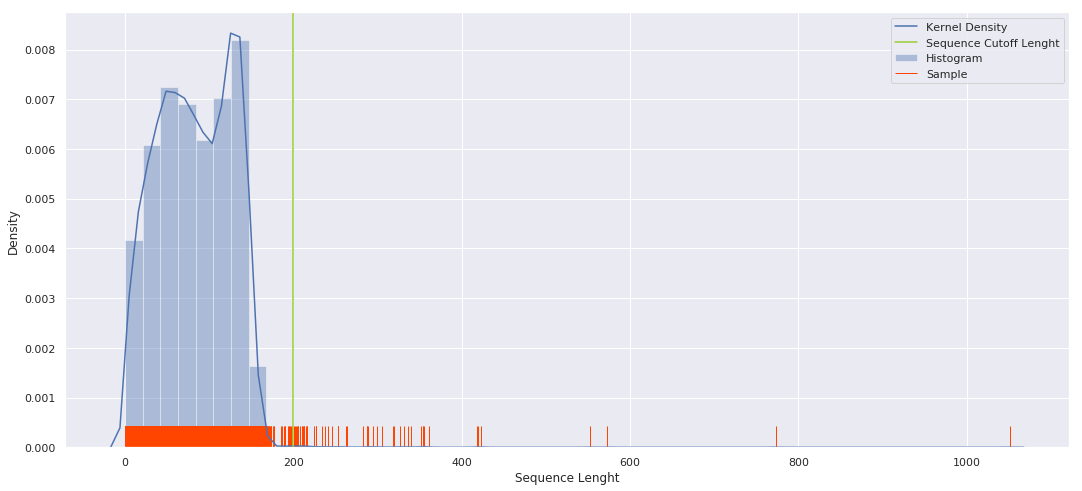

In [13]:
sns.distplot(
    sequence_lenghts,
    hist_kws=dict(label='Histogram'),
    kde=True,
    kde_kws=dict(label='Kernel Density'),
    rug=True,
    norm_hist=False,
    rug_kws=dict(color='orangered', label='Sample'),
    axlabel='Sequence Lenght',
)
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='yellowgreen', label='Sequence Cutoff Lenght')
plt.ylabel('Density')
plt.legend();

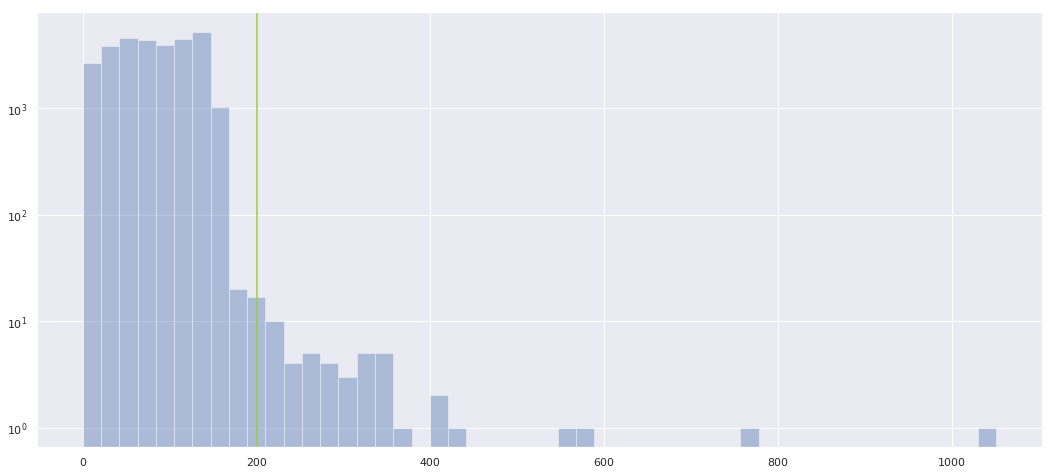

In [14]:
sns.distplot(sequence_lenghts, kde=False)
plt.gca().set_yscale('log')
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='yellowgreen');

In [15]:
sum(sequence_lenghts > MAX_SEQUENCE_LENGTH)/len(sequence_lenghts)

0.0017666666666666666

In [16]:
x_train = keras.preprocessing.sequence.pad_sequences(reviews_df.review_vec_seq, maxlen=MAX_SEQUENCE_LENGTH)
y_train = reviews_df.rating

In [19]:
# plotting

def plot_history(history, skip_first_n_epochs=0):
    """Show information about the training"""
    
    # plot every train-valid metric pair separately
    for metric in history:
        if not metric.startswith('val_'):
            x = np.arange(len(history[metric]))+1

            y_train = history[metric][skip_first_n_epochs:]
            y_valid = history['val_'+metric][skip_first_n_epochs:]

            # make the plots
            plt.plot(x, y_train)
            plt.plot(x, y_valid)

            # add a legend
            plt.legend([metric, 'val_'+metric], fontsize='large')

            # title with min/max stats
            plt.title(
                f'{metric.upper()} - '
                f'min/max [train: {min(y_train):.3f}/{max(y_train):.3f}, '
                f'valid: {min(y_valid):.3f}/{max(y_valid):.3f}]'
            )
            
            # label and show
            plt.xlabel('epoch')
            plt.show()

In [101]:
keras.activations.tanh?

In [20]:
model = keras.models.Sequential()
model.add(layers.InputLayer(x_train.shape[1:]))
model.add(layers.CuDNNLSTM(64))
model.add(layers.Dense(1, activation='linear'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          128000    
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 64)                24960     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 153,155
Trainable params: 153,155
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(
    optimizer='adam',
    loss='msle',
    metrics=['mae', 'mse'],
)

Instructions for updating:
Use tf.cast instead.
Train on 22500 samples, validate on 7500 samples
Epoch 1/10
22500/22500 [==============================] - 24s 1ms/step - loss: 0.7974 - acc: 0.6715 - val_loss: 0.7185 - val_acc: 0.6929
Epoch 2/10
22500/22500 [==============================] - 2s 94us/step - loss: 0.6861 - acc: 0.7315 - val_loss: 0.6726 - val_acc: 0.7279
Epoch 3/10
22500/22500 [==============================] - 2s 95us/step - loss: 0.6261 - acc: 0.7580 - val_loss: 0.6596 - val_acc: 0.7373
Epoch 4/10
22500/22500 [==============================] - 2s 93us/step - loss: 0.5979 - acc: 0.7726 - val_loss: 0.7661 - val_acc: 0.6841
Epoch 5/10
22500/22500 [==============================] - 2s 94us/step - loss: 0.5708 - acc: 0.7852 - val_loss: 0.6290 - val_acc: 0.7636
Epoch 6/10
22500/22500 [==============================] - 2s 94us/step - loss: 0.5521 - acc: 0.7956 - val_loss: 0.6333 - val_acc: 0.7624
Epoch 7/10
22500/22500 [==============================] - 2s 94us/step - loss: 0.

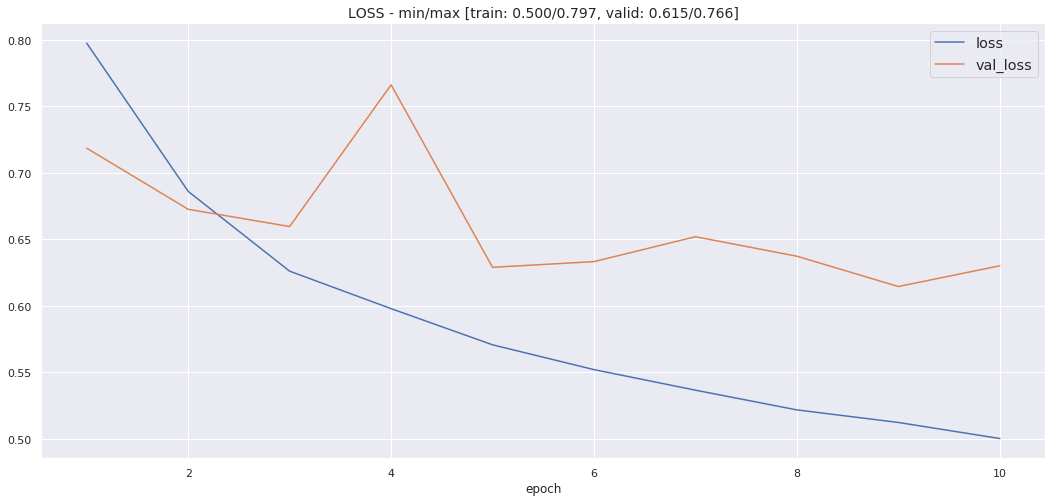

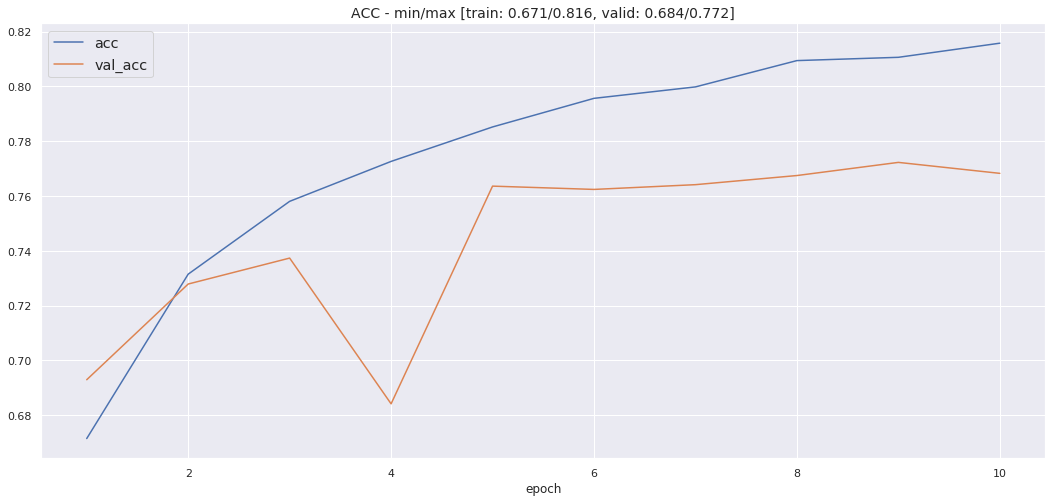

In [22]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_split=0.25,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            'model-epoch_{epoch:02d}-val_loss_{val_loss:.2f}.hdf5',
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            period=1,
        ),
    ],
)

plot_history(history.history)